In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

def load_and_inspect_results(tile_id):
    """Charge et inspecte les résultats pour une tuile"""
    
    # Charger le fichier de résultats
    results = np.load(f"preds/{tile_id}_weighted_voting.npy", allow_pickle=True).item()
    
    print(f"🔍 Inspection des résultats pour la tuile {tile_id}")
    print("=" * 50)
    
    # Structure générale
    print("📋 Clés disponibles:")
    for key in results.keys():
        print(f"  - {key}")
    
    print("\n📏 Informations sur les prédictions:")
    
    # Prédiction finale (vote pondéré)
    final_pred = results['semantic_weighted_voting']
    print(f"  Prédiction finale: {final_pred.shape}, dtype: {final_pred.dtype}")
    print(f"  Classes présentes: {np.unique(final_pred)}")
    print(f"  Distribution des classes:")
    unique, counts = np.unique(final_pred, return_counts=True)
    for cls, count in zip(unique, counts):
        percentage = (count / final_pred.size) * 100
        print(f"    Classe {cls}: {count} pixels ({percentage:.2f}%)")
    
    # Prédictions individuelles
    individual_preds = results['individual_predictions']
    print(f"\n🔄 Prédictions individuelles ({len(individual_preds)} folds):")
    for i, pred in enumerate(individual_preds):
        print(f"  Fold {i+1}: {pred.shape}, classes: {len(np.unique(pred))}")
    
    # Cartes de confiance
    confidence_maps = results['confidence_maps']
    print(f"\n📊 Cartes de confiance:")
    for i, conf_map in enumerate(confidence_maps):
        print(f"  Fold {i+1}: shape {conf_map.shape}, confiance moy: {conf_map.mean():.3f}, max: {conf_map.max():.3f}")
    
    # Shapes originales
    if 'original_shapes' in results:
        original_shapes = results['original_shapes']
        print(f"\n📐 Shapes originales avant redimensionnement:")
        for i, shape in enumerate(original_shapes):
            print(f"  Fold {i+1}: {shape}")
    
    return results

# Exemple d'utilisation
results = load_and_inspect_results("S2_10000")

🔍 Inspection des résultats pour la tuile S2_10000
📋 Clés disponibles:
  - semantic_weighted_voting
  - confidence_maps
  - individual_predictions
  - original_shapes

📏 Informations sur les prédictions:
  Prédiction finale: (128, 128), dtype: int64
  Classes présentes: [ 0  1  2  3  4  6  7  8  9 11 12 13 14 16]
  Distribution des classes:
    Classe 0: 3773 pixels (23.03%)
    Classe 1: 2134 pixels (13.02%)
    Classe 2: 1 pixels (0.01%)
    Classe 3: 667 pixels (4.07%)
    Classe 4: 8 pixels (0.05%)
    Classe 6: 4 pixels (0.02%)
    Classe 7: 6 pixels (0.04%)
    Classe 8: 2 pixels (0.01%)
    Classe 9: 14 pixels (0.09%)
    Classe 11: 377 pixels (2.30%)
    Classe 12: 9235 pixels (56.37%)
    Classe 13: 18 pixels (0.11%)
    Classe 14: 132 pixels (0.81%)
    Classe 16: 13 pixels (0.08%)

🔄 Prédictions individuelles (5 folds):
  Fold 1: (128, 128), classes: 9
  Fold 2: (128, 128), classes: 6
  Fold 3: (128, 128), classes: 8
  Fold 4: (128, 128), classes: 11
  Fold 5: (128, 128), cla

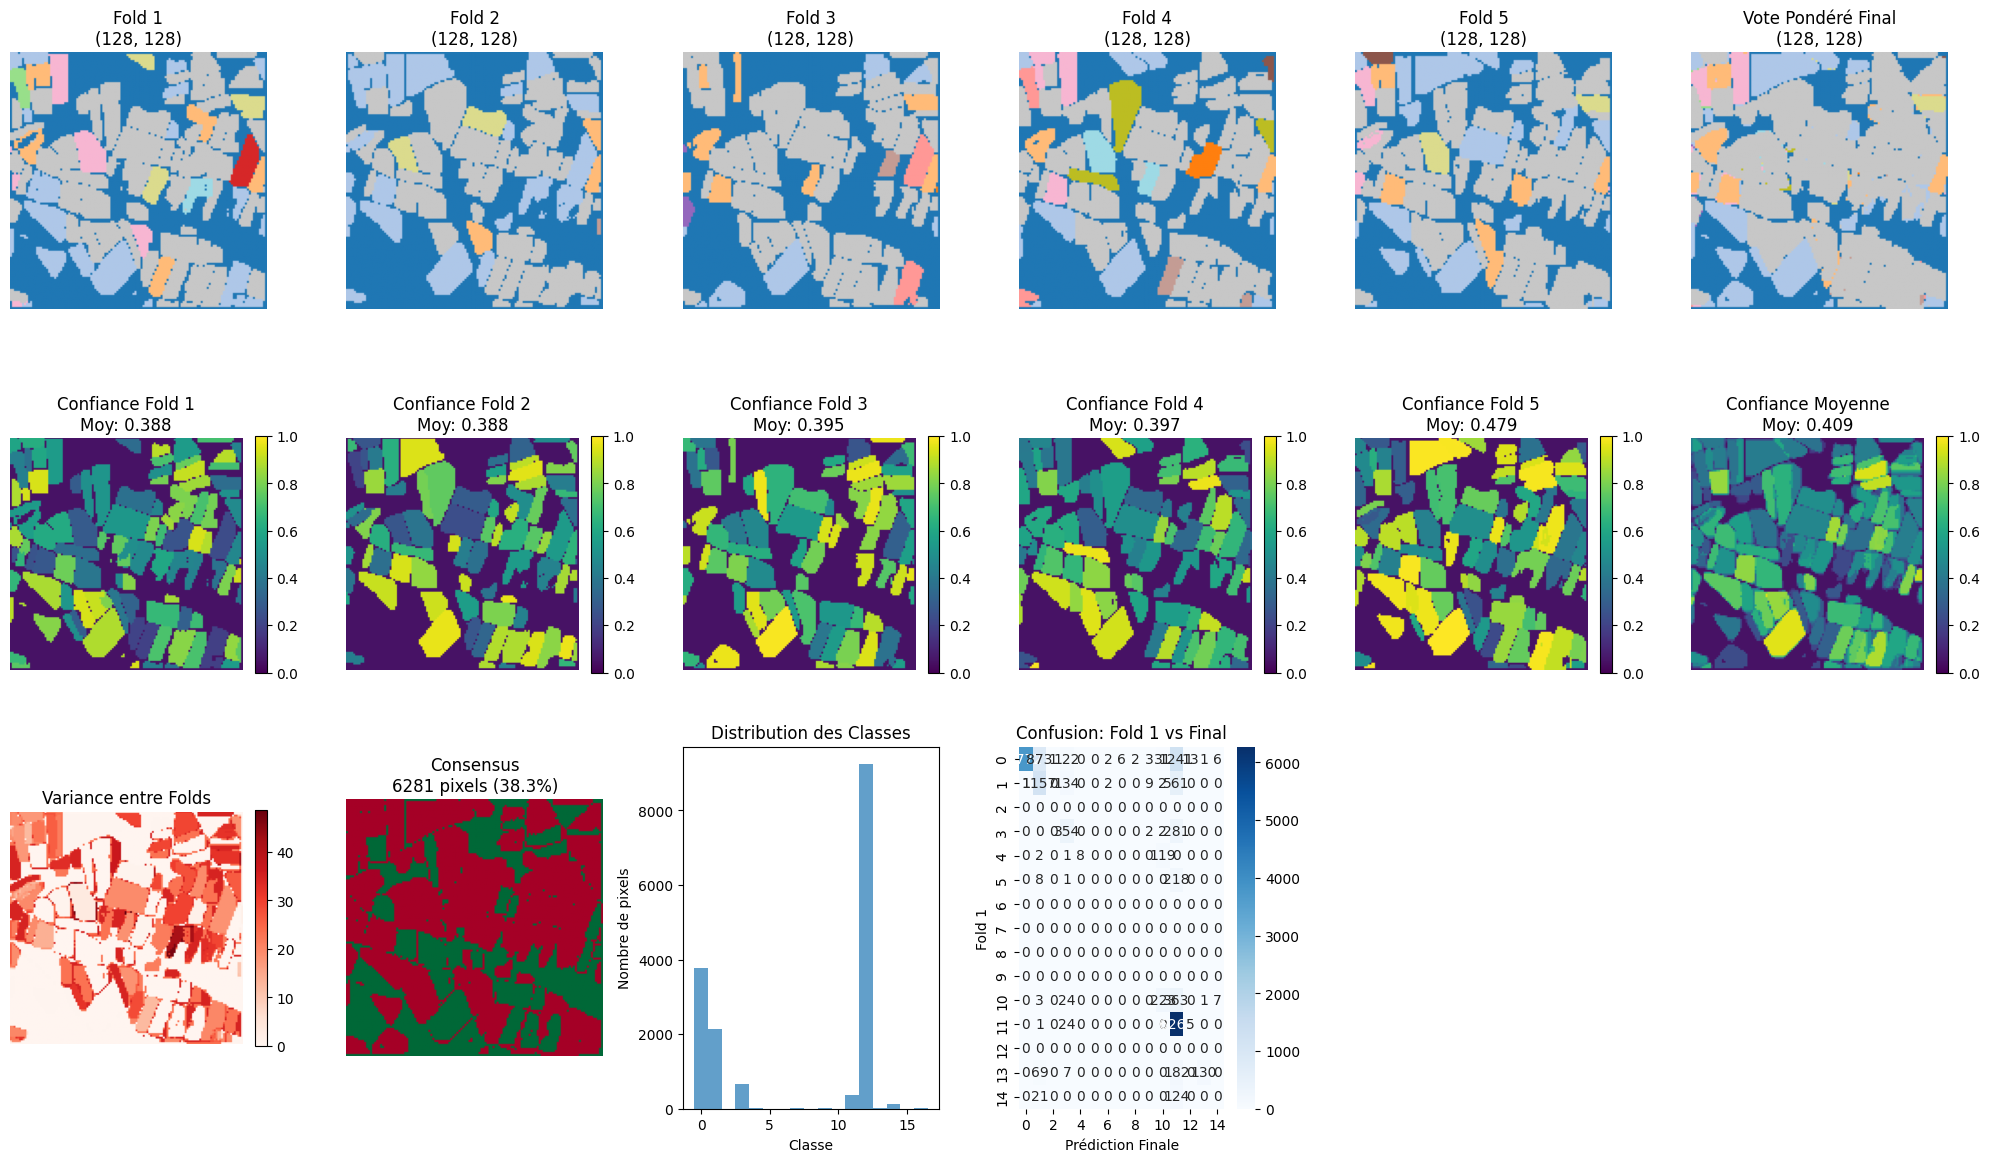

In [4]:
def visualize_results(tile_id, results=None, figsize=(20, 12)):
    """Visualise les résultats de segmentation"""
    
    if results is None:
        results = np.load(f"preds/{tile_id}_weighted_voting.npy", allow_pickle=True).item()
    
    final_pred = results['semantic_weighted_voting']
    individual_preds = results['individual_predictions']
    confidence_maps = results['confidence_maps']
    
    n_folds = len(individual_preds)
    
    # Créer la figure
    fig, axes = plt.subplots(3, n_folds + 1, figsize=figsize)
    
    # Colormap pour les classes
    n_classes = max(np.max(final_pred), max(np.max(pred) for pred in individual_preds)) + 1
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    cmap = ListedColormap(colors)
    
    # Ligne 1: Prédictions individuelles + finale
    for i, pred in enumerate(individual_preds):
        im1 = axes[0, i].imshow(pred, cmap=cmap, vmin=0, vmax=n_classes-1)
        axes[0, i].set_title(f'Fold {i+1}\n{pred.shape}')
        axes[0, i].axis('off')
    
    # Prédiction finale
    im1 = axes[0, -1].imshow(final_pred, cmap=cmap, vmin=0, vmax=n_classes-1)
    axes[0, -1].set_title(f'Vote Pondéré Final\n{final_pred.shape}')
    axes[0, -1].axis('off')
    
    # Ligne 2: Cartes de confiance
    for i, conf_map in enumerate(confidence_maps):
        im2 = axes[1, i].imshow(conf_map, cmap='viridis', vmin=0, vmax=1)
        axes[1, i].set_title(f'Confiance Fold {i+1}\nMoy: {conf_map.mean():.3f}')
        axes[1, i].axis('off')
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
    
    # Carte de confiance moyenne
    mean_confidence = np.mean(confidence_maps, axis=0)
    im2 = axes[1, -1].imshow(mean_confidence, cmap='viridis', vmin=0, vmax=1)
    axes[1, -1].set_title(f'Confiance Moyenne\nMoy: {mean_confidence.mean():.3f}')
    axes[1, -1].axis('off')
    plt.colorbar(im2, ax=axes[1, -1], fraction=0.046)
    
    # Ligne 3: Analyses comparatives
    # Variance entre prédictions
    pred_stack = np.stack(individual_preds, axis=0)
    pred_variance = np.var(pred_stack.astype(float), axis=0)
    im3 = axes[2, 0].imshow(pred_variance, cmap='Reds')
    axes[2, 0].set_title('Variance entre Folds')
    axes[2, 0].axis('off')
    plt.colorbar(im3, ax=axes[2, 0], fraction=0.046)
    
    # Consensus (où tous les folds sont d'accord)
    consensus = np.std(pred_stack.astype(float), axis=0) == 0
    axes[2, 1].imshow(consensus, cmap='RdYlGn')
    axes[2, 1].set_title(f'Consensus\n{consensus.sum()} pixels ({consensus.mean()*100:.1f}%)')
    axes[2, 1].axis('off')
    
    # Histogramme des classes
    axes[2, 2].hist(final_pred.flatten(), bins=np.arange(n_classes+1)-0.5, alpha=0.7)
    axes[2, 2].set_title('Distribution des Classes')
    axes[2, 2].set_xlabel('Classe')
    axes[2, 2].set_ylabel('Nombre de pixels')
    
    # Matrice de confusion entre folds (exemple fold 1 vs final)
    if len(individual_preds) > 0:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(individual_preds[0].flatten(), final_pred.flatten())
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[2, 3], cmap='Blues')
        axes[2, 3].set_title('Confusion: Fold 1 vs Final')
        axes[2, 3].set_xlabel('Prédiction Finale')
        axes[2, 3].set_ylabel('Fold 1')
    
    # Masquer les axes restants
    for i in range(4, n_folds + 1):
        if i < len(axes[2]):
            axes[2, i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'visualization_{tile_id}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualiser
visualize_results("S2_10000", results)

In [5]:
def analyze_consensus_quality(tile_id):
    """Analyse la qualité du consensus entre folds"""
    
    results = np.load(f"preds/{tile_id}_weighted_voting.npy", allow_pickle=True).item()
    
    individual_preds = results['individual_predictions']
    final_pred = results['semantic_weighted_voting']
    confidence_maps = results['confidence_maps']
    
    pred_stack = np.stack(individual_preds, axis=0)
    
    print(f"📊 Analyse de consensus pour la tuile {tile_id}")
    print("=" * 50)
    
    # 1. Accord unanime
    unanimous = np.all(pred_stack == pred_stack[0], axis=0)
    print(f"🎯 Accord unanime: {unanimous.sum()} pixels ({unanimous.mean()*100:.2f}%)")
    
    # 2. Accord majoritaire (>50% des folds)
    majority_votes = []
    for i in range(pred_stack.shape[1]):
        for j in range(pred_stack.shape[2]):
            pixel_votes = pred_stack[:, i, j]
            unique, counts = np.unique(pixel_votes, return_counts=True)
            max_votes = np.max(counts)
            majority_votes.append(max_votes >= len(individual_preds) // 2 + 1)
    
    majority_consensus = np.array(majority_votes).reshape(pred_stack.shape[1:])
    print(f"🗳️  Accord majoritaire: {majority_consensus.sum()} pixels ({majority_consensus.mean()*100:.2f}%)")
    
    # 3. Zones de désaccord
    disagreement = ~majority_consensus
    print(f"⚠️  Zones de désaccord: {disagreement.sum()} pixels ({disagreement.mean()*100:.2f}%)")
    
    # 4. Corrélation avec la confiance
    mean_confidence = np.mean(confidence_maps, axis=0)
    consensus_confidence = mean_confidence[unanimous]
    disagreement_confidence = mean_confidence[disagreement]
    
    if len(consensus_confidence) > 0 and len(disagreement_confidence) > 0:
        print(f"📈 Confiance dans zones consensuelles: {consensus_confidence.mean():.3f} ± {consensus_confidence.std():.3f}")
        print(f"📉 Confiance dans zones de désaccord: {disagreement_confidence.mean():.3f} ± {disagreement_confidence.std():.3f}")
    
    # 5. Classes les plus problématiques
    disagreement_classes = final_pred[disagreement]
    if len(disagreement_classes) > 0:
        unique_disagree, counts_disagree = np.unique(disagreement_classes, return_counts=True)
        print(f"\n🚨 Classes avec le plus de désaccord:")
        for cls, count in zip(unique_disagree, counts_disagree):
            total_cls = np.sum(final_pred == cls)
            percentage = (count / total_cls) * 100 if total_cls > 0 else 0
            print(f"  Classe {cls}: {count}/{total_cls} pixels ({percentage:.1f}%)")
    
    return {
        'unanimous': unanimous,
        'majority_consensus': majority_consensus,
        'disagreement': disagreement,
        'consensus_confidence': consensus_confidence,
        'disagreement_confidence': disagreement_confidence
    }

# Analyser la qualité
consensus_analysis = analyze_consensus_quality("S2_10000")

📊 Analyse de consensus pour la tuile S2_10000
🎯 Accord unanime: 6281 pixels (38.34%)
🗳️  Accord majoritaire: 14006 pixels (85.49%)
⚠️  Zones de désaccord: 2378 pixels (14.51%)
📈 Confiance dans zones consensuelles: 0.345 ± 0.370
📉 Confiance dans zones de désaccord: 0.406 ± 0.076

🚨 Classes avec le plus de désaccord:
  Classe 1: 181/2134 pixels (8.5%)
  Classe 3: 363/667 pixels (54.4%)
  Classe 4: 6/8 pixels (75.0%)
  Classe 7: 1/6 pixels (16.7%)
  Classe 9: 10/14 pixels (71.4%)
  Classe 11: 333/377 pixels (88.3%)
  Classe 12: 1366/9235 pixels (14.8%)
  Classe 13: 1/18 pixels (5.6%)
  Classe 14: 117/132 pixels (88.6%)


In [6]:
def detailed_confidence_diagnosis(tile_id):
    """Diagnostic approfondi des problèmes de confiance"""
    
    results = np.load(f"preds/{tile_id}_weighted_voting.npy", allow_pickle=True).item()
    individual_preds = results['individual_predictions']
    confidence_maps = results['confidence_maps']
    
    print(f"🔍 DIAGNOSTIC DÉTAILLÉ DE CONFIANCE - Tuile {tile_id}")
    print("=" * 60)
    
    # 1. Statistiques détaillées par fold
    for i, (pred, conf) in enumerate(zip(individual_preds, confidence_maps)):
        print(f"\nFold {i+1}:")
        print(f"  📊 Prédiction - Shape: {pred.shape}")
        print(f"    Classes: {len(np.unique(pred))}, Min: {pred.min()}, Max: {pred.max()}")
        print(f"  📊 Confiance - Shape: {conf.shape}")
        print(f"    Min: {conf.min():.4f}, Max: {conf.max():.4f}")
        print(f"    Moyenne: {conf.mean():.4f}, Médiane: {np.median(conf):.4f}")
        print(f"    Std: {conf.std():.4f}")
        
        # Distribution de confiance
        conf_bins = [0, 0.1, 0.2, 0.5, 0.8, 1.0]
        hist, _ = np.histogram(conf, bins=conf_bins)
        print(f"  📈 Distribution confiance:")
        for j in range(len(conf_bins)-1):
            pct = (hist[j] / conf.size) * 100
            print(f"    [{conf_bins[j]:.1f}-{conf_bins[j+1]:.1f}]: {hist[j]} pixels ({pct:.1f}%)")
    
    # 2. Vérifier si les confidences sont correctement calculées
    print(f"\n🔬 VÉRIFICATION DES CALCULS DE CONFIANCE:")
    return confidence_maps

def check_raw_model_outputs(tile_id):
    """Vérifier les sorties brutes du modèle pour un fold"""
    
    # Recharger et examiner les outputs bruts
    s3_prefix = "s3://antoinelesauvage/vergers-france/patches_2018_128/"
    dataset = S3SinglePatchDataset(s3_prefix, [tile_id])
    dataloader = DataLoader(dataset, batch_size=1)
    
    model = load_model_fold(1)  # Tester avec le fold 1
    
    for batch in dataloader:
        data = batch["data"][0].unsqueeze(0).cuda()
        
        # Normalisation
        mean = torch.tensor(norm_vals["Fold_1"]["mean"]).float().cuda()
        std = torch.tensor(norm_vals["Fold_1"]["std"]).float().cuda()
        mean = mean.reshape(1, -1, 1, 1)
        std = std.reshape(1, -1, 1, 1)
        x_norm = (data - mean) / std
        
        T, C, H, W = x_norm.shape[1:]
        batch_positions = torch.linspace(0, 1, steps=T).unsqueeze(0).cuda()
        
        with torch.no_grad():
            output = model(x_norm, batch_positions=batch_positions)
            
            print(f"🔍 OUTPUTS BRUTS - Tuile {tile_id}, Fold 1:")
            for key, value in output.items():
                if torch.is_tensor(value):
                    print(f"  {key}: shape {value.shape}")
                    print(f"    dtype: {value.dtype}, device: {value.device}")
                    print(f"    min: {value.min().item():.6f}, max: {value.max().item():.6f}")
                    print(f"    mean: {value.mean().item():.6f}, std: {value.std().item():.6f}")
                    
                    # Pour pano_semantic, examiner en détail
                    if key == "pano_semantic":
                        print(f"    🎯 PANO_SEMANTIC DÉTAILLÉ:")
                        if len(value.shape) == 4:  # (B, C, H, W)
                            print(f"      Logits par classe (moyenne):")
                            for c in range(min(value.shape[1], 10)):  # Max 10 classes affichées
                                class_logits = value[0, c]
                                print(f"        Classe {c}: min={class_logits.min().item():.4f}, "
                                     f"max={class_logits.max().item():.4f}, "
                                     f"mean={class_logits.mean().item():.4f}")
                            
                            # Calculer les probabilities
                            probs = F.softmax(value, dim=1)
                            print(f"      Probabilities après softmax:")
                            print(f"        Min: {probs.min().item():.6f}, Max: {probs.max().item():.6f}")
                            print(f"        Mean: {probs.mean().item():.6f}")
                            
                            # Confiance maximale par pixel
                            max_probs = probs.max(dim=1)[0]
                            print(f"      Confiance maximale par pixel:")
                            print(f"        Min: {max_probs.min().item():.6f}, Max: {max_probs.max().item():.6f}")
                            print(f"        Mean: {max_probs.mean().item():.6f}")
            
            return output
        break

# Lancer les diagnostics
conf_maps = detailed_confidence_diagnosis("S2_10000")
raw_output = check_raw_model_outputs("S2_10000")

🔍 DIAGNOSTIC DÉTAILLÉ DE CONFIANCE - Tuile S2_10000

Fold 1:
  📊 Prédiction - Shape: (128, 128)
    Classes: 9, Min: 0, Max: 16
  📊 Confiance - Shape: (128, 128)
    Min: 0.0500, Max: 0.9389
    Moyenne: 0.3876, Médiane: 0.3682
    Std: 0.3143
  📈 Distribution confiance:
    [0.0-0.1]: 6073 pixels (37.1%)
    [0.1-0.2]: 367 pixels (2.2%)
    [0.2-0.5]: 3338 pixels (20.4%)
    [0.5-0.8]: 3900 pixels (23.8%)
    [0.8-1.0]: 2706 pixels (16.5%)

Fold 2:
  📊 Prédiction - Shape: (128, 128)
    Classes: 6, Min: 0, Max: 14
  📊 Confiance - Shape: (128, 128)
    Min: 0.0500, Max: 0.9688
    Moyenne: 0.3885, Médiane: 0.3176
    Std: 0.3482
  📈 Distribution confiance:
    [0.0-0.1]: 7088 pixels (43.3%)
    [0.1-0.2]: 0 pixels (0.0%)
    [0.2-0.5]: 3160 pixels (19.3%)
    [0.5-0.8]: 2491 pixels (15.2%)
    [0.8-1.0]: 3645 pixels (22.2%)

Fold 3:
  📊 Prédiction - Shape: (128, 128)
    Classes: 8, Min: 0, Max: 12
  📊 Confiance - Shape: (128, 128)
    Min: 0.0500, Max: 0.9904
    Moyenne: 0.3949, Médi

NameError: name 'S3SinglePatchDataset' is not defined

In [7]:
def compare_with_individual_folds(tile_id):
    """Compare le résultat final avec chaque fold individuel"""
    
    results = np.load(f"preds/{tile_id}_weighted_voting.npy", allow_pickle=True).item()
    
    individual_preds = results['individual_predictions']
    final_pred = results['semantic_weighted_voting']
    
    print(f"🔄 Comparaison avec les folds individuels pour {tile_id}")
    print("=" * 60)
    
    for i, pred in enumerate(individual_preds):
        # Accord pixel par pixel
        agreement = (pred == final_pred)
        agreement_pct = agreement.mean() * 100
        
        # Classes communes
        classes_individual = set(np.unique(pred))
        classes_final = set(np.unique(final_pred))
        common_classes = classes_individual.intersection(classes_final)
        
        print(f"Fold {i+1}:")
        print(f"  📊 Accord avec final: {agreement_pct:.2f}%")
        print(f"  🏷️  Classes individuelles: {len(classes_individual)}")
        print(f"  🏷️  Classes communes: {len(common_classes)}/{len(classes_final)}")
        print(f"  📐 Shape: {pred.shape} -> {final_pred.shape}")
        print()

compare_with_individual_folds("S2_10000")

🔄 Comparaison avec les folds individuels pour S2_10000
Fold 1:
  📊 Accord avec final: 72.69%
  🏷️  Classes individuelles: 9
  🏷️  Classes communes: 8/14
  📐 Shape: (128, 128) -> (128, 128)

Fold 2:
  📊 Accord avec final: 64.61%
  🏷️  Classes individuelles: 6
  🏷️  Classes communes: 6/14
  📐 Shape: (128, 128) -> (128, 128)

Fold 3:
  📊 Accord avec final: 68.16%
  🏷️  Classes individuelles: 8
  🏷️  Classes communes: 8/14
  📐 Shape: (128, 128) -> (128, 128)

Fold 4:
  📊 Accord avec final: 69.07%
  🏷️  Classes individuelles: 11
  🏷️  Classes communes: 11/14
  📐 Shape: (128, 128) -> (128, 128)

Fold 5:
  📊 Accord avec final: 78.39%
  🏷️  Classes individuelles: 7
  🏷️  Classes communes: 7/14
  📐 Shape: (128, 128) -> (128, 128)

